# 손동작 분류 경진대회

## 데이터 불러오기

In [88]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [18]:
pd.set_option('display.max_columns', 15)

In [54]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/손동작-분류/Data/train.csv')

In [55]:
df.shape

(2335, 34)

In [56]:
df.drop('id', axis=1, inplace=True)

## 센서 데이터를 이미지로 변환

In [89]:
df.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,...,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,...,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,-1.122174,-1.024673,-0.672769,-0.147724,-0.327494,-0.423462,0.676275,...,-0.081374,-0.370812,-0.726941,-0.809534,-0.495062,-0.743585,1.523340
std,11.486353,7.399859,26.519159,15.551500,11.461970,7.314322,26.869479,...,25.923355,15.541803,11.636507,7.469744,25.291238,16.300385,1.118221
min,-94.746969,-63.942094,-122.195138,-111.870691,-94.147972,-70.916786,-105.956553,...,-105.751637,-105.890010,-74.977182,-74.006065,-121.097086,-123.876153,0.000000
25%,-4.036597,-4.031957,-14.878500,-7.116633,-3.968687,-3.957699,-13.937806,...,-14.096840,-8.004561,-3.981055,-3.988965,-13.998874,-7.873898,1.000000
50%,-0.951398,-1.015582,-0.961088,-0.890469,-0.871690,-0.804810,0.058910,...,-0.954791,-0.989293,-0.889780,-0.928504,-0.955684,-1.019547,2.000000
75%,2.895540,2.140456,13.974075,6.110973,2.970387,3.006144,13.934438,...,13.903783,5.922250,2.972719,2.519426,13.926128,5.121679,3.000000
max,68.876142,39.913391,127.124171,102.015561,89.059852,34.923040,120.046277,...,123.179253,111.137925,54.098746,35.896503,125.974107,104.959621,3.000000


`-` 32개의 센서피쳐는 하나의 픽셀을 의미하는 것이 아닐까?(손동작 이미지를 32개의 픽셀로 나눈 것 같다)

`-` 0부근에 값이 많고 변수마다 분포가 유사함(종모양) 

`-` $4\times 8$ 배열로 변환하고 이를 확인해보자($8\times 4$로 해도 상관없다)

`-` 위는 각 target의 sensor_1부터 sensor_32까지 각각의 평균이다

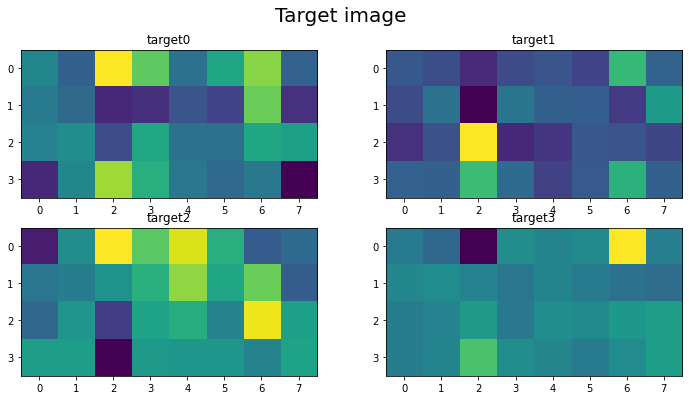

In [83]:
plt.figure(figsize=(12, 6))
for i in range(4) :
    plt.subplot(2, 2, i+1)
    plt.title(f'target{i}')
    plt.imshow(df.groupby('target').agg('mean').iloc[i,:].to_numpy().reshape(4, 8))
plt.suptitle('Target image', fontsize=20)
plt.show()

`-` 위의 4가지 그림을 보면 target마다 평균적으로 값의 차이가 있음을 알 수 있다

## DNN 설계

In [121]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

`-` 일단 데이터를 정규화시켜주자(0부터 1까지)

In [96]:
target = df['target']
df.drop('target', axis=1, inplace=True)

In [109]:
X = df.applymap(lambda x: (x - df.to_numpy().min()) / (df.to_numpy().max() - df.to_numpy().min())).copy()

In [115]:
X = np.array(X).reshape(-1, 4, 8, 1) ## 8(세로)*4(가로)*1(흑백) 이미지가 -1(2335)개 존재함

In [116]:
len(X)

2335